In [1]:
with open("chart.jpg", "rb") as input_file:
    whole_data = input_file.read()
data = whole_data[-10237440:]

In [2]:
import numpy as np
import math, os, sys
from matplotlib import pyplot as plt 

In [3]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import raw_process4 as raw_process

In [4]:
bayer_pattern = np.array([[2, 1], [1, 0]])
raw_w = 3282  # for v1.3 w = 2592
raw_h = 2480  # for v1.3 h = 1944
img = np.zeros((raw_h, raw_w))
stride = math.ceil(raw_w * 10 / 8 / 32) * 32
for y in range(raw_h):
    for x in range(raw_w // 4):
        word = data[y * stride + x * 5: y * stride + x * 5 + 5]
        img[y, 4 * x    ] = (word[0] << 2) | ((word[4] >> 6) & 3) 
        img[y, 4 * x + 1] = (word[1] << 2) | ((word[4] >> 4) & 3) 
        img[y, 4 * x + 2] = (word[2] << 2) | ((word[4] >> 2) & 3) 
        img[y, 4 * x + 3] = (word[3] << 2) | ((word[4]     ) & 3)

In [5]:
# Crop to the multiple of 32x32
w = 3264
h = 2464
img_clp = img[0:h, 8:8+w]

In [6]:
blacklevel = [64] * 4
blc_raw = raw_process.black_level_correction(img_clp, blacklevel)

In [7]:
wbg = np.array([1.128, 1, 2.546, 1])
wb_raw = raw_process.white_balance_Bayer(blc_raw, wbg, bayer_pattern)

In [8]:
dms_img = raw_process.advanced_demosaic(wb_raw, bayer_pattern)

In [9]:
ccm_matrix = (6022,-2314,394,-936,4728,310,300,-4324,8126)
img_ccm = raw_process.color_correction_matrix(dms_img, ccm_matrix)

In [10]:
img_ccm[img_ccm > 1023] = 1023
img_no_shading = raw_process.gamma_correction(img_ccm, 2.2)

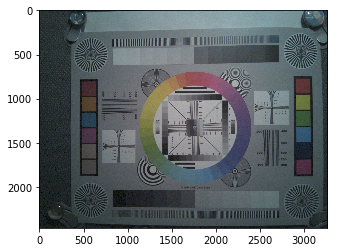

In [11]:
outimg = img_no_shading.copy()
outimg = outimg.reshape((h, w, 3))
outimg[outimg < 0] = 0
plt.imshow(outimg)

In [ ]:
raw_process.write(img_no_shading, "chart_without_shading_correction.png")

In [15]:
par = [np.array([6.07106808e-07, 9.60556906e-01]), 
       np.array([6.32044369e-07, 9.70694361e-01]), 
       np.array([6.28455183e-07, 9.72493898e-01]), 
       np.array([9.58743579e-07, 9.29427169e-01])]

In [18]:
gain_map = np.zeros((h, w))
for y in range(0, h, 2):
    for x in range(0, w, 2):
        r2 = (y - center_y) * (y - center_y) + (x - center_x) * (x - center_x)
        gain = [par[i][0] * r2 + par[i][1] for i in range(4)]
        gain_map[y, x] = gain[0]
        gain_map[y, x+1] = gain[1]
        gain_map[y+1, x] = gain[2]
        gain_map[y+1, x+1] = gain[3]

In [19]:
lsc_raw = blc_raw * gain_map

In [21]:
wb_raw = raw_process.white_balance_Bayer(lsc_raw, wbg, bayer_pattern)
dms_img = raw_process.advanced_demosaic(wb_raw, bayer_pattern)
img_ccm = raw_process.color_correction_matrix(dms_img, ccm_matrix)
img_ccm[img_ccm > 1023] = 1023
img_shading = raw_process.gamma_correction(img_ccm, 2.2)

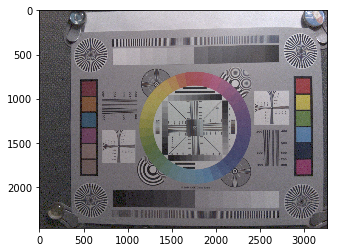

In [22]:
outimg = img_shading.copy()
outimg = outimg.reshape((h, w, 3))
outimg[outimg < 0] = 0
plt.imshow(outimg)

In [ ]:
raw_process.write(img_shading, "chart_with_shading_correction.png")